# CSC 3170 Analysis Part

## Random Generation

We assume that there are $n$ potential customers and their arrivals follow $X_i$ ~ Poisson($\lambda$), where $i$ indicates customers' id.
It is well known that $\sum_{i}X_i$~ Poisson($n \cdot \lambda$) because of the property of poisson distribution. Now, without loss of generality we further assume there are totally 2 types of chips: Chip1 and Chip2. Chip1 requires operation A while Chip2 requires B. Indeed choosing the package first and then invoking arrival is equivalent to first invoking the arrival and then choosing chips in certain probability.

We now show the way to generate poisson arrival in continuous time. Given $N_t$ the number of arrivals during time period $t$. $Y_t$ the time it takes for one additional arrival assuming someone arrives at time $t$. By definition, followings hold:

$(Y_t > y) \equiv (N_t = N_{t+y})$

$P(Y_t < y) = 1 - P(Y_t > y)$

$P(Y_t < y) = 1 - P(N_{t+y} = N_t)$

$P(N_{t+y} = N_t) = P(N_y)$

$P(N_{t+y} = N_t) = \frac{\lambda y}{0!} e^{-\lambda y} = e^{- \lambda y}$

Which is just the exponential distribution. Note that $\lambda$ is the rate. In our context, we just need to adjust the rate of different kinds of arrivals. Also, we assume the processing time also follows an exponential distribution. A good property of exponential distribution is that it is memoryless, and thus a time point of an event can "restart" the exponential simulation

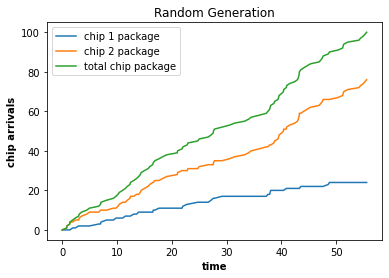

In [3]:
from cProfile import label
from math import gamma
from matplotlib import pyplot as plt  
import math       
import numpy


t = 0 
t_ls = [0]
chip1_ls = [0]
chip2_ls = [0]
chip_ls = [0]

chip1_r = 0.2
chip2_r = 0.8
lam = 0.002
n = 1000

for i in range(100):
    u = numpy.random.uniform()
    tau = -math.log(1-u)*(1/(lam*n))
    u_flag = numpy.random.uniform()
    if u_flag < chip1_r:
        chip1_ls.append(chip1_ls[-1]+1)
        chip2_ls.append(chip2_ls[-1])
    else:
        chip2_ls.append(chip2_ls[-1]+1)
        chip1_ls.append(chip1_ls[-1])
    chip_ls.append(chip_ls[-1] + 1)
    t_ls.append(t_ls[-1] + tau)


fig, ax = plt.subplots()
ax.plot(t_ls, chip1_ls, label = 'chip 1 package')
ax.plot(t_ls, chip2_ls, label = 'chip 2 package')
ax.plot(t_ls, chip_ls, label = 'total chip package')
ax.set_xlabel('time', fontweight='bold')
ax.set_ylabel('chip arrivals', fontweight='bold')
ax.set_title('Random Generation')
ax.legend()

plt.show()

## Shortest Processing Time First (SPTS) Simulation

We start from the simplest situation. We do not care about the economic cost and the traveling time, but only the processing time. In this case, once there is a request we find the matched machine to process the request package.

$\textbf{Assumption}$: To simplify the problem, we set four companies: first has 2 machines both for operation A; second has 2 machines both for operation B; third and fourth has 2 machines capable of A and B respectively.

$\textbf{Implementation}$: We are concerned about the analysis speed. We list several approaches for comparisons:

1. Directly go through companies and machines

2. Keep all machines in a single queue

3. Keep machines in multiple queues for different operations. Maintain pointers from queues to machine info block and from machine info block to queues

The time cost of 1 is $O(m)$, where $m = \sum_{i=1}^{n} m_i$ and $m_i$ is the machine number in company $i$

The time cost of 2 is $O(m^{'})$, where $m^{'}$ is the available machine numbers

The time cost of 3 is $O(1)$

Only disadvantage of 3 is that we need to keep the update of queue. For instance, suppose now the machine supports both operation A and B, assigning A to a chip not only removes A from the queue for A but also the queue for B.

one chip 2 package being processed by company 1 machine 0
machine 0 in company 1 finishes chip 2
one chip 2 package being processed by company 1 machine 1
machine 1 in company 1 finishes chip 2
new chip 1 package arrival and being processed by company 0 machine 0
one chip 2 package being processed by company 2 machine 1
machine 1 in company 2 finishes chip 2
one chip 2 package being processed by company 3 machine 1
machine 1 in company 3 finishes chip 2
one chip 2 package being processed by company 1 machine 0
machine 0 in company 1 finishes chip 2
one chip 2 package being processed by company 1 machine 1
machine 1 in company 1 finishes chip 2
one chip 2 package being processed by company 2 machine 1
machine 1 in company 2 finishes chip 2
new chip 1 package arrival and being processed by company 0 machine 1
new chip 1 package arrival and being processed by company 2 machine 0
one chip 2 package being processed by company 3 machine 1
machine 1 in company 3 finishes chip 2
one chip 2 pac

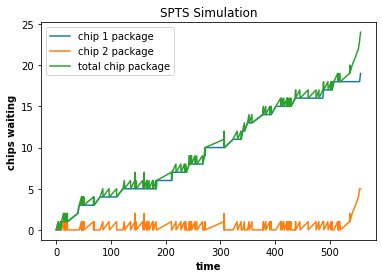

In [14]:
from cProfile import label
from math import gamma
from matplotlib import pyplot as plt  
import math       
import numpy as np


t = 0 
t_ls = [0]
chip1_ls = [0]
chip2_ls = [0]
chip_ls = [0]


# A only for chip 1 and B only for chip 2
lam = 0.002
n = 100
count_package = 0
proc_A_r = 0.95
proc_B_r = 2.825

A_q = [0, 1, 20, 30]
B_q = [10, 11, 21, 31]


def get_x(index):
    return math.floor(index/10)

def get_y(index):
    return index%10

def get_index(x, y):
    return x*10 + y

tau_table = np.array([[0, 0],
                    [0, 0],
                    [0, 0],
                    [0, 0]])
    

while count_package < n:
    is_arrival = True
    u1 = np.random.uniform()
    u2 = np.random.uniform()
    tau1 = -math.log(1-u1)*(1/(lam*n*0.2))
    tau2 = -math.log(1-u2)*(1/(lam*n*0.8))

    tau_proc_min = math.inf
    i_min = -1
    j_min = -1
    machine_type = -1

    for i in range(4):
        for j in range(2):
            if tau_table[i][j] == 0:
                continue
            else:
                u_proc = np.random.uniform()
                my_index = get_index(i, j)
                tau_proc = 0
                if my_index in (0, 1, 20, 30):
                    tau_proc = -math.log(1-u_proc)*(1/(proc_A_r))
                else:
                    tau_proc = -math.log(1-u_proc)*(1/(proc_B_r))
            if tau_proc < tau_proc_min:
                tau_proc_min = tau_proc
                i_min = i
                j_min = j
                if my_index in (0, 1, 20, 30):
                    machine_type = 1
                else:
                    machine_type = 2

    if tau_proc_min < min(tau1, tau2):
        is_arrival = False

    if is_arrival:
        count_package += 1
        if tau1 < tau2:
            t_ls.append(t_ls[-1] + tau1)
            chip_ls.append(chip_ls[-1] + 1)
            chip1_ls.append(chip1_ls[-1] + 1)
            chip2_ls.append(chip2_ls[-1])
            if (len(A_q) == 0):
                print("new chip 1 package arrival, waiting for free machine ...")
            else:
                machine_index = A_q.pop(0)
                x = get_x(machine_index)
                y = get_y(machine_index)
                print("new chip 1 package arrival and being processed by company {} machine {}".format(x, y))
                tau_table[x][y] = proc_A_r
        else:
            t_ls.append(t_ls[-1] + tau2)
            chip_ls.append(chip_ls[-1] + 1)
            chip2_ls.append(chip2_ls[-1] + 1)
            chip1_ls.append(chip1_ls[-1])
            if (len(B_q) == 0):
                print("new chip 2 package arrival, waiting for free machine ...")
            else:
                machine_index = B_q.pop(0)
                x = get_x(machine_index)
                y = get_y(machine_index)
                print("one chip 2 package being processed by company {} machine {}".format(x, y))
                tau_table[x][y] = proc_B_r

    if not is_arrival:
        t_ls.append(t_ls[-1] + tau_proc_min)
        machine_index = get_index(i_min, j_min)
        if machine_type == 1:
            print("machine {} in company {} finishes chip 1".format(j_min, i_min))
            A_q.append(machine_index)
            tau_table[i_min][j_min] = 0

            chip_ls.append(chip_ls[-1] - 1)
            chip1_ls.append(chip1_ls[-1] - 1)
            chip2_ls.append(chip2_ls[-1])

            if chip1_ls[-1] > 0:
                machine_index = A_q.pop(0)
                x = get_x(machine_index)
                y = get_y(machine_index)
                print("one chip 1 package being processed by company {} machine {}".format(x, y))
                tau_table[x][y] = proc_A_r
        else:
            print("machine {} in company {} finishes chip 2".format(j_min, i_min))
            B_q.append(machine_index)
            tau_table[i_min][j_min] = 0

            chip_ls.append(chip_ls[-1] - 1)
            chip1_ls.append(chip1_ls[-1])
            chip2_ls.append(chip2_ls[-1] - 1)

            if chip2_ls[-1] > 0:
                machine_index = B_q.pop(0)
                x = get_x(machine_index)
                y = get_y(machine_index)
                print("one chip 2 package being processed by company {} machine {}".format(x, y))
                tau_table[x][y] = proc_A_r
                

fig, ax = plt.subplots()
ax.plot(t_ls, chip1_ls, label = 'chip 1 package')
ax.plot(t_ls, chip2_ls, label = 'chip 2 package')
ax.plot(t_ls, chip_ls, label = 'total chip package')
ax.set_xlabel('time', fontweight='bold')
ax.set_ylabel('chips waiting', fontweight='bold')
ax.set_title('SPTS Simulation')
ax.legend()

plt.show()

## Consider Travel Cost: Traveling Salesman Problem

Now if we take the traveling cost (both time and money) into consideration, we need to solve TSP problem. The assumption of the modeling is that there enough machines in some companies, so that we usually only need to consider the companies that can always offer production services.